# 필요 라이브러리 설치

In [ ]:
!pip3 install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 4.6 MB/s 


# 필요 라이브러리 import

In [ ]:
# pytorch 계열 라이브러리
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio

# sklearn 라이브러리 계열
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 정규표현식 사용용도
import re

# 그 외 기본 라이브러리
import os
import pickle5 as pickle
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import time
from typing import List
import IPython
import matplotlib.pyplot as plt

from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score, roc_auc_score

# 경고 제거용
import warnings
warnings.filterwarnings('ignore')

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')

else:
    DEVICE = torch.device('cpu')

print(f'Using Pytorch version: {torch.__version__}, Device: {DEVICE}')

Using Pytorch version: 1.12.1+cu113, Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Structure

## Sub Models

In [ ]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x

## Main model

In [ ]:
class SimpleErrorDetectionModel(nn.Module):
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SimpleErrorDetectionModel, self).__init__()
        n_feats = n_feats//2
        n_feats2 = (64)//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])

        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)

        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )
    
    def forward(self, mfcc):
        x = self.cnn(mfcc)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)

        x = self.birnn_layers(x)
        output = self.classifier(x)

        return output

# 필요 클래스 및 함수

## TextToVector

In [ ]:
class TextToVector():
    def __init__(self, vocab = None, textList = None):
        if vocab == None:
            self.vocab = {}
        else:
            self.vocab = vocab
        
        if textList != None:
            self.vocab = self.madeVocab(textList, self.vocab)
    
    def IncreaseString(self, simpleString, mfccLen):
        simpleCharList = list(simpleString)

        lenSimpleChar = len(simpleCharList)
        increaseRate, randomIndexNum = mfccLen // lenSimpleChar, mfccLen % lenSimpleChar
        increaseString = ''
        increaseRates = np.full((lenSimpleChar), increaseRate)

        for i in np.random.randint(0, lenSimpleChar, size = randomIndexNum):
            increaseRates[i] += 1

        for index, incRate in enumerate(increaseRates):
            for i in range(incRate):
                increaseString += simpleCharList[index]
        
        return increaseString
    
    def madeVocab(self, strList, vocab = None):
        if vocab != None:
            self.vocab = vocab
        self.vocab.setdefault("'", 0)

        vocabList = list(self.vocab.keys())
        vocabFreauency = {}

        for tempText in strList:
            for tempStr in tempText:
                for tempChar in tempStr:
                    if tempChar not in vocabList:
                        vocabFreauency.setdefault(tempChar, 0)
                        vocabFreauency[tempChar] += 1

            
        vocabFreauency = dict(sorted(vocabFreauency.items(), reverse = True, key = lambda item: item[1]))

        for v in vocabFreauency:
            self.vocab.setdefault(v, len(self.vocab))        

        return self.vocab
    
    def TextToId(self, TextList, mfccLens, padLn=None):
        idList = []
        
        for index, tempText in enumerate(TextList):
            strList = list(tempText)
            lenSimpleChar = len(tempText)
            increaseRate = mfccLens[index] // lenSimpleChar
            strT = self.IncreaseString(tempText, mfccLens[index])

            if padLn == None:
                padLen = len(strT)
            else:
                padLen = padLn

            strList = list(strT)
            tempIdList = []

            for s in strList:
                tempIdList.append(self.vocab[s])

            tempIdList = np.concatenate((tempIdList, np.zeros(padLn-mfccLens[index])), axis=0)
            idList.append(tempIdList)

        return np.array(idList)
    
    def TextToVector(self, TextList, mfccLens, padLn=None, overlapPercent=0):
        textVector = []
        for index, strT in enumerate(TextList):
            lenSimpleChar = len(strT)
            increaseRate = mfccLens[index] // lenSimpleChar
            overlapNum = int(increaseRate * overlapPercent)
            strT = self.IncreaseString(strT, mfccLens[index])

            if padLn == None:
                padLen = len(strT)
            else:
                padLen = padLn

            strList = list(strT)
            if len(self.vocab)%2 == 0:
                oneHotVector = np.zeros((padLen, len(self.vocab)))
            else:
                oneHotVector = np.zeros((padLen, len(self.vocab) + 1))              

            for i, s in enumerate(strT):
                oneHotVector[i][self.vocab[s]] = 1
                if overlapNum + i < len(strT):
                    oneHotVector[overlapNum + i][self.vocab[s]] = 1
                if i - overlapNum >= 0:
                    oneHotVector[i - overlapNum][self.vocab[s]] = 1

            textVector.append(oneHotVector)

        return np.array(textVector)

In [ ]:
textToVectorPath = '/content/drive/MyDrive/Data enhancement code for speech recognition/00 Data/03 textToVector/textToVector.p'
with open(textToVectorPath, 'rb') as f:
    textToVector = pickle.load(f)

## 평가 메트릭 관련 함수

In [ ]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

In [ ]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')

text_transform = TextTransform()

def GreedyDecoder(output, labels, label_lengths, blank_label=4, collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2)
	decodes = []
	targets = []
	for i, args in enumerate(arg_maxes):
		decode = []
		targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
		for j, index in enumerate(args):
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j-1]:
					continue
				decode.append(index.item())
		decodes.append(text_transform.int_to_text(decode))
	return decodes, targets

## 라벨 데이터 전처리 함수

In [ ]:
def LabelToInt(labelText):
    output = []
    labelList = list(labelText)
    for l in labelList:
        if l =='*':
            output.append(3)
        elif l == ' ':
            output.append(1) 
        else:
            output.append(2)

    output =  np.array(output)
    return output

In [ ]:
def intPadding(output, padLen = 512):
    padList = np.zeros(padLen-len(output))
    return np.concatenate([output, padList])

## 데이터셋 구조

In [ ]:
class sPED_Dataset(Dataset):
    def __init__(
        self, mfcc, inputText,labels, mfccLens, textToVector
    ):
        self.mfcc = mfcc
        self.mfccLens = mfccLens
        self.realLens = self.mfcc.shape[3]
        self.labels = [LabelToInt(l) for l in labels]
        self.lenLabels = [len(i) for i in self.labels]
        self.labels = [intPadding(l) for l in self.labels]
        self.textVector = textToVector.TextToId(inputText, mfccLens, padLn=self.realLens)
        

    def __getitem__(self, i):
        return ((self.mfcc[i], ) + (self.mfccLens[i], ) + (self.textVector[i],) + (self.labels[i], ) + (self.lenLabels[i], ))

    def __len__(self):
        return (len(self.labels))

# 모델 로드

In [ ]:
model = SimpleErrorDetectionModel(
    n_cnn_layers = 3,
    n_rnn_layers = 5,
    rnn_dim = 128,
    n_class = 5,
    n_feats = 20,
    stride = 2,
    dropout = 0.1
).to(DEVICE)

In [ ]:
print(model)

SimpleErrorDetectionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
      )
    )
    (1): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((10

# Hyper parameter setting

In [ ]:
learning_rate = 1e-4
epochs = 32
optimizer = optim.AdamW(model.parameters(), learning_rate)
criterion = nn.CTCLoss(blank=4).to(DEVICE)

# Dataloader 파일 로드

In [ ]:
trainNormalPath = '/content/drive/MyDrive/Data enhancement code for speech recognition/03 Dataloader/train/normal'
trainNormalList = os.listdir(trainNormalPath)
trainNormalList = [trainNormalPath + '/' + tName for tName in trainNormalList]

trainErrorPath = '/content/drive/MyDrive/Data enhancement code for speech recognition/03 Dataloader/train/error'
trainErrorList = os.listdir(trainErrorPath)
trainErrorList = [trainErrorPath + '/' + tName for tName in trainErrorList]

validNormalPath = '/content/drive/MyDrive/Data enhancement code for speech recognition/03 Dataloader/validation/normal'
validNormalList = os.listdir(validNormalPath)
validNormalList = [validNormalPath + '/' + tName for tName in validNormalList]

validErrorPath = '/content/drive/MyDrive/Data enhancement code for speech recognition/03 Dataloader/validation/error'
validErrorList = os.listdir(validErrorPath)
validErrorList = [validErrorPath + '/' + tName for tName in validErrorList]

testNormalPath = '/content/drive/MyDrive/Data enhancement code for speech recognition/03 Dataloader/test/normal'
testNormalList = os.listdir(testNormalPath)
testNormalList = [testNormalPath + '/' + tName for tName in testNormalList]

testErrorPath = '/content/drive/MyDrive/Data enhancement code for speech recognition/03 Dataloader/test/error'
testErrorList = os.listdir(testErrorPath)
testErrorList = [testErrorPath + '/' + tName for tName in testErrorList]

In [ ]:
train_cer_history, train_wer_history = [], []
valid_cer_history, valid_wer_history = [], []

validMinCer, validMinWer = 1000000, 1000000

for e in tqdm_notebook(range(epochs)):
    # train
    for trainFileName in tqdm_notebook(trainErrorList):
        with open(trainFileName, 'rb') as f:
            train_dataloader40 = pickle.load(f)
        model.train()
        
        allTrain_cer, allTrain_wer = [], []
        train_cer, train_wer = [], []
        for batch_id, (mfcc, mfccLens, textVector, label, lenLabels) in enumerate(train_dataloader40):
            mfcc = mfcc.float().to(DEVICE)
            label = label.float().to(DEVICE)
            optimizer.zero_grad()

            output = model(mfcc)

            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, label, mfccLens//2, lenLabels)
            loss.backward()
            optimizer.step()

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), label, lenLabels)
            for j in range(len(decoded_preds)):
                train_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                train_wer.append(wer(decoded_targets[j], decoded_preds[j]))

        print('--------------------------------------------------------------------------------------')
        print(loss.item())
        for i in range(len(decoded_preds) // 4):
            print(f'label: \t{decoded_targets[i]}')
            print(f'pred: \t{decoded_preds[i]}')

        avg_cer = sum(train_cer)/len(train_cer)
        avg_wer = sum(train_wer)/len(train_wer)

        print(f'avg_cer: {avg_cer} avg_wer: {avg_wer}')
        print('--------------------------------------------------------------------------------------')
        allTrain_cer.append(avg_cer)
        allTrain_wer.append(avg_wer)

        train_cer, trian_wer = [], [] 
    
    print('--------------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------------')
    print(f'Train Epoch: {e}')
    print(f'train_cer: {np.mean(allTrain_cer)}')
    print(f'train_wer: {np.mean(allTrain_wer)}')
    train_cer_history.append(np.mean(allTrain_cer))
    train_wer_history.append(np.mean(allTrain_wer))
    print('--------------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------------')

    test_cer, test_wer = [], []
    for validFileName in tqdm_notebook(validErrorList):
        with open(validFileName, 'rb') as f:
            valid_dataloader40 = pickle.load(f)
        model.eval()
        
        for batch_id, (mfcc, mfccLens, textVector, label, lenLabels) in enumerate(train_dataloader40):
            mfcc = mfcc.float().to(DEVICE)
            label = label.float().to(DEVICE)

            output = model(mfcc)

            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), label, lenLabels)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

    print('--------------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------------')
    print('Validation!!!')
    print(loss.item())
    for i in range(len(decoded_preds) // 4):
        print(f'label: \t{decoded_targets[i]}')
        print(f'pred: \t{decoded_preds[i]}')
    
    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    print(f'avg_cer: {avg_cer} avg_wer: {avg_wer}')
    valid_cer_history.append(avg_cer)
    valid_wer_history.append(avg_wer)
    print('--------------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------------')
    print('--------------------------------------------------------------------------------------')

    test_cer, test_wer = [], [] 

    # valid cer이 가장 작은 경우 저장
    if validMinCer > avg_cer:
        validMinCer = avg_cer
        PATH = '/content/drive/MyDrive/Data enhancement code for speech recognition/04 Models/mfcc/bestCer/minCERModel.p'
        torch.save(model.state_dict(), PATH)   

    # valid wer이 가장 작은 경우 저장
    if validMinWer > avg_wer:
        validMinWer = avg_wer
        PATH = '/content/drive/MyDrive/Data enhancement code for speech recognition/04 Models/mfcc/bestWer/minWERModel.p'
        torch.save(model.state_dict(), PATH)

Output hidden; open in https://colab.research.google.com to view.

# Epoch 별 Train and Valid WER and CER score

## WER

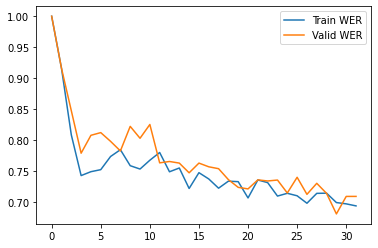

In [ ]:
x = np.arange(len(train_wer_history))
plt.plot(x, train_wer_history)
plt.plot(x, valid_wer_history)
plt.legend(['Train WER', 'Valid WER'])
plt.show()

## CER

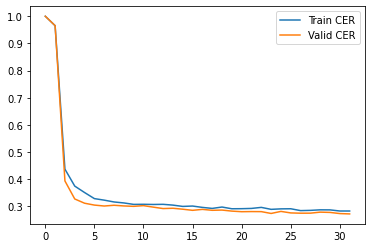

In [ ]:
x = np.arange(len(train_cer_history))
plt.plot(x, train_cer_history)
plt.plot(x, valid_cer_history)
plt.legend(['Train CER', 'Valid CER'])
plt.show()

In [24]:
werhistoryPath = '/content/drive/MyDrive/Data enhancement code for speech recognition/04 Models/mfcc/werHistroy.p'
with open(werhistoryPath, 'wb') as f:
    pickle.dump(train_wer_history, f, pickle.HIGHEST_PROTOCOL)

cerhistoryPath = '/content/drive/MyDrive/Data enhancement code for speech recognition/04 Models/mfcc/cerHistroy.p'
with open(cerhistoryPath, 'wb') as f:
    pickle.dump(train_cer_history, f, pickle.HIGHEST_PROTOCOL)

# Best WER model Test

In [ ]:
PATH = '/content/drive/MyDrive/Data enhancement code for speech recognition/04 Models/mfcc/bestWer/minWERModel.p'
model.load_state_dict(torch.load(PATH))
model.eval()

test_cer, test_wer = [], []
for testFileName in tqdm_notebook(testErrorList):
    with open(testFileName, 'rb') as f:
        test_dataloader40 = pickle.load(f)

    for batch_id, (mfcc, mfccLens, textVector, label, lenLabels) in enumerate(test_dataloader40):
        mfcc = mfcc.float().to(DEVICE)
        label = label.float().to(DEVICE)

        output = model(mfcc)

        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), label, lenLabels)
        for j in range(len(decoded_preds)):
            test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
            test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print('Test!!!')
print(loss.item())

for i in range(len(decoded_preds) // 4):
    print(f'label: \t{decoded_targets[i]}')
    print(f'predt: \t{decoded_preds[i]}')

avg_cer = sum(test_cer)/len(test_cer)
avg_wer = sum(test_wer)/len(test_wer)

print(f'avg_cer: {avg_cer} avg_wer: {avg_wer}')
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')

test_cer, test_wer = [], [] 

  0%|          | 0/35 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
Test!!!
0.7086250185966492
label: 	b aaaaa aa aaa aa
predt: 	b aaa a a aa
label: 	aaaa b a aa a aaa aa aa a aa a aa a aaa
predt: 	a aa a a aa aa aa aa a aa aa aa
label: 	b aaaa aa aa a aa a a a a aaaa
predt: 	b aa aa a a aa aaa aa a a aaa
label: 	b aa aa a aaa aaaa aaaa
predt: 	a a a a aa aa aa a aaa
avg_cer: 0.27581673491303044 avg_wer: 0.6830507073407315
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
--------------------------------

# Best CER model Test

In [ ]:
PATH = '/content/drive/MyDrive/Data enhancement code for speech recognition/04 Models/mfcc/bestCer/minCERModel.p'
model.load_state_dict(torch.load(PATH))
model.eval()

test_cer, test_wer = [], []
for testFileName in tqdm_notebook(testErrorList):
    with open(testFileName, 'rb') as f:
        test_dataloader40 = pickle.load(f)

    for batch_id, (mfcc, mfccLens, textVector, label, lenLabels) in enumerate(test_dataloader40):
        mfcc = mfcc.float().to(DEVICE)
        label = label.float().to(DEVICE)

        output = model(mfcc)

        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), label, lenLabels)
        for j in range(len(decoded_preds)):
            test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
            test_wer.append(wer(decoded_targets[j], decoded_preds[j]))

print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print('Test!!!')
print(loss.item())

for i in range(len(decoded_preds) // 4):
    print(f'label: \t{decoded_targets[i]}')
    print(f'pred: \t{decoded_preds[i]}')

avg_cer = sum(test_cer)/len(test_cer)
avg_wer = sum(test_wer)/len(test_wer)

print(f'avg_cer: {avg_cer} avg_wer: {avg_wer}')
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')
print('--------------------------------------------------------------------------------------')

test_cer, test_wer = [], [] 

  0%|          | 0/35 [00:00<?, ?it/s]

--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
Test!!!
0.7086250185966492
label: 	bb aaaa aaa
pred: 	b a a aaa
label: 	aa aaa a b a aa aaaa a
pred: 	a a aa b a aa a aaa
label: 	a aaa aaaa aaa bbbb aaa
pred: 	b a a aa aa a aa aaa
label: 	bb aaaa aaaa aa aaa
pred: 	b aaa aaa a aaa a
avg_cer: 0.2743759589064174 avg_wer: 0.7142478746863861
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------
